<a href="https://colab.research.google.com/github/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/blob/main/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ĐỒ ÁN LẬP TRÌNH SONG SONG ỨNG DỤNG**

# BACKGROUND REMOVAL WITH GRABCUT AND SUPERPIXELS

## Giáo viên: Trần Trung Kiên

### Sinh viên:
- 1712568	KIM ĐÌNH LỘC	
- 1712787	NGUYỄN VĂN THÌN	
- 1712898	TRẦN VIỆT VĂN	


#0. Ý NGHĨA TỪ NGỮ

**GrabCut** là phương pháp để phân đoạn một cách chính xác tiền cảnh của hình ảnh khỏi hậu cảnh.

 <img src="https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/Illustrated%20image/Grabcut.png"
     width="400" 
     height="" />


**Superpixel** là kết quả của việc nhóm các pixel theo cảm nhận màu sắc, hoặc theo cách nhìn khác, đó là kết quả của sự phân đoạn hình ảnh.([Tu-chemnitz.de. 2022. Superpixel | TU Chemnitz](https://www.tu-chemnitz.de/etit/proaut/en/research/superpixel.html))


**Superpixel segmentation** là quá trình phân đoạn hình ảnh thành nhiều superpixels.

 <img src="https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/Illustrated%20image/Dog_SLIC.jpg" 
     width="400"  />



#1. MÔ TẢ ỨNG DỤNG

**Ứng dụng mà nhóm chọn là BACKGROUND REMOVAL WITH GRABCUT AND SUPERPIXELS**.  

Lý do chọn đề tài:

Đối với grabcut, kết quả phân đoạn hình ảnh với Foreground có thể mất vài vị trí. Để tăng cường hình ảnh tốt hơn ta chọn superpixels với mong muốn lắp đầy các lỗ trống trong Foreground mà vẫn tuân thủ đường viền.

<img src="https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/Illustrated%20image/compair.jpg.png" 
     width="1218" 
     height="300" />

**Input:**  
 - Một tấm ảnh RGB
 - Mô hình yolov3 được đào tạo sẵn với coco dataset.

 
  
  <img src="https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/Illustrated%20image/Dog.JPG" 
     width="640" 
     height="455" />

**Output**  
Ảnh đầu vào được remove background.  
<img src="https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/Illustrated%20image/Dog_output.jpg" 
     width="640" 
     height="455" />


- Ý nghĩa của ứng dụng:
  - Hỗ trợ tách/lọc nền trong việc chỉnh sửa ảnh.
  - Nghiên cứu về segmentation việc xoá background.
  - Giảm độ phức tạp của các bước xử lý ảnh của vấn đề mở rộng bài toán của mô hình này.
- Lý do cần tăng tốc ứng dụng:
	- Ứng dụng sẽ chạy chậm nếu cài đặt tuần tự.
	- Nhu cầu xử lý dữ liệu lớn, ảnh có độ phân giải cao thì việc tạo superpixels yêu cầu tính toán lớn do độ phức tạp thuật toán cao với khoảng O(n^3).
- Tiềm năng song song hóa của ứng dụng: 
  - Song song hoá việc chuyển từ hệ màu RGB sang hệ màu CELAB, matching superpixels và việc tính toán từ trung tâm cụm đến từng pixel trong vùng 
  - Thực hiện song song hoá quá trình xử lý hình ảnh.
- Thách thức:
  - Quá trình song song hoá tác vụ kết nối các pixel trong SLIC gần như không thể.
  - Quá trình convolution gặp khó khăn khi có quá nhiều vòng lặp.
  - Việc song song hoá mô hình GRABCUT là không thể.
  - Thời gian xử lý lâu hơn so với model Machine Learning/deep learning.
  - Độ chính xác không cao so với deep learning.

#2. QUÁ TRÌNH THỰC HIỆN

<img src="https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/Illustrated%20image/Model/timeline.JPG" 
     width="1152" 
     height="360" />

#3. CÀI ĐẶT TUẦN TỰ

Đối với cài đặt tuần tự và song song. Chúng ta đều thực hiện thử trên 1 ảnh duy nhất với kích thước 640x455 như hình dưới.

  <img src="https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/Illustrated%20image/Dog.JPG" 
     width="640" 
     height="455" />

In [ ]:
%%capture
#@title Download các mô hình và code cần thiết { display-mode: "form" }
!wget https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/Illustrated%20image/Dog.JPG
import matplotlib.pyplot as plt
import cv2
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names
!wget https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/src/sequential.py
!wget https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/src/seq_jit.py
!wget https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/src/seq_jit_v2.py
!wget https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/src/Parallel_v1.py
!wget https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/src/parallel_v2.py

##3.1. Mô hình tuần tự, không jit

###3.1.1. Thiết kế

<img src="https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/Illustrated%20image/Model/non_jit.JPG" 
     width="1152" 
     height="" />

#### a. Superpixels

Trong mô hình này SLIC Superpixels có 5 bước gồm:

*   Convert to CIELAB
*   Initialize cluster center
*   Loops to find matching pixels
*   Compute new cluster
*   Connect cluster



**Convert to CIELAB**

Ref: https://docs.opencv.org/3.4/de/d25/imgproc_color_conversions.html#color_convert_rgb_lab

Việc convert diễn ra trong 2 giai đoạn, RGB to XYZ và XYZ to CIELAB

<img src="https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/Illustrated%20image/BRG2LAB.png"
     width="520" 
     height="358" />

**Initialize cluster center**

Việc khởi tạo các cluster center được dựa trên độ lớn khoảng cách *segmentSize* (kí hiệu là S) ở input đầu vào.


<img src="https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/Illustrated%20image/Initialize_cluster_center_1.png"
     width="315" 
     height="" />

Các cluster sẽ cách đều nhau một khoảng *S* và chúng ta sẽ có vùng liên kết xung quanh mỗi cluster là 2*S*x2*S*.  
Vùng liên kết là vùng mà các pixel có khả năng gộp lại thành các superpixels.

<img src="https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/Illustrated%20image/Initialize_cluster_center_2.png"
     width="359" 
     height="" />

**Loops to find matching pixels**

Việc tìm các superpixels dựa vào thước đo khoảng cách của từng pixel trong vùng liên kết

<img src="https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/Illustrated%20image/find_matching_pixels_1.png"
     width="400" 
     height=""/>

**Compute new cluster**

Việc tính toán cluster mới dựa vào thước đo khoảng cách Ds ở phía trên.  
Khoảng cách từ cluster nhỏ hơn khoảng cách ban đầu, thì pixel đó là phần tử của cluster mới.

**Connect cluster**

Việc connect cluster dựa trên ý tưởng:  
Sau khi hoàn thành việc tạo ra các superpixels, sẽ có khả năng tạo ra những cluster nhỏ hoặc siêu nhỏ.  
Việc có nhiều cluster siêu nhỏ khiến cho số lượng cluster tăng lên, làm mất nhiều thời gian cho việc xử lý.

Minh hoạ về việc connect cluster:
Ảnh trái gồm 3 cluster. Trong đó có 1 cluster chỉ có 1 pixel. Mong muốn của chúng ta sẽ gộp các cluster siêu nhỏ với các cluster khác, làm giảm độ lớn của các centers.  
<img src="https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/Illustrated%20image/Connect_cluster_1.png"
     width="600" 
     height=""/>

#### b. YOLOv3 và Grabcut

Đối với grabcut, để có thể xác định được tiền cảnh và hậu cảnh. Mô hình cần một chỉ định bouding box do người dùng đưa vào. Do đó ta cần mô hình yolov3 để detection các object và đưa vào bouding box lớn nhất.
Output của grabcut là một mảng phân biêt giữa tiền cảnh(Màu vàng) và hậu cảnh(màu xanh)

 <img src="https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/Illustrated%20image/Grabcut.png"
     width="400" 
     height="" />


#### c. Xử lý hình ảnh và output

Sau khi chúng ta có outline(SLIC) và mask(Grabcut) gồm các clusters từ SLIC và mask từ Grabcut. Thì ta tiến hành tạo một segment mask.  
Đặt:  
- $S_i$ là tổng pixel của superpixels thứ $i$
- $S_mask$ là tổng pixel của superpixels thuộc mask  
Nếu:  
\begin{align}
    \frac{ S_i }{S_{mask}} > threshold
\end{align}  
Thì: superpixels đó được xác định là superpixel chứa các pixel của object

Sau khi hoàn thành segment mask. Ta tiến hành gaussianblur để có một đường viền mịn hơn và đặt ngưỡng để xác định viền hoặc các superpixel siêu nhỏ có thể được gom lại với các superpixels khác.

Việc còn lại là ánh xạ hình ảnh từ srcImage sang dstImage dựa trên segment mask.

### 3.1.2. Thử nghiệm

In [ ]:
#@title Run { display-mode: "both" }
%%time
!python /content/sequential.py /content/Dog.JPG

CPU times: user 2.06 s, sys: 294 ms, total: 2.35 s
Wall time: 4min 48s


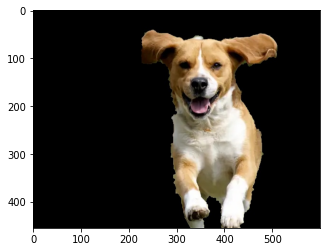

In [ ]:
#@title Show output
image=cv2.imread("/content/Dog.JPG_output.jpg")
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

##3.2. Mô hình tuần tự, jit lần 1

###3.2.1. Thiết kế

Dựa trên mô hình tuần tự chưa jit, nhóm tiến hành jit các hàm có thể được jit ngay tại thời điểm đó

<img src="https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/Illustrated%20image/Model/jit_v1.JPG" 
     width="1152" 
     height="360" />

###3.2.2. Thực nghiệm

In [ ]:
#@title Run
%%time
!python /content/seq_jit.py /content/Dog.JPG

CPU times: user 1.6 s, sys: 213 ms, total: 1.81 s
Wall time: 3min 43s


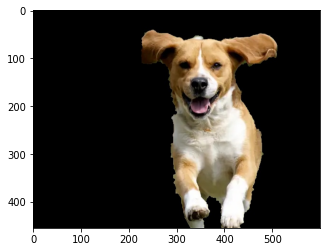

In [ ]:
#@title Show output
image=cv2.imread("/content/Dog.jpg")
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

##3.3. Mô hình tuần tự, jit lần 2

Mô hình tuần tự và jit lần thứ 2 dựa trên kinh nghiệm của việc jit lần 1, sự khó khăn của code khi song song quá lần 1 gặp nhiều vướng mắc, khó khăn.  
Từ đó, nhóm quyết định code mô hình tuần tự, jit lần 2 để giải quyết các khó khăn đồng thời tạo nền tảng tốt hơn đến việc song song hoá lần 2

###3.3.1. Thiết kế

<img src="https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/Illustrated%20image/Model/jit_v2_1.JPG" 
     width="1152" 
     height="360" />

**Quyết định:**
- Bỏ connected clustervới lý do: Không song song hoá được, mất nhiều thời gian tính toán, khiến cho output xấu hơn.
- Tái cấu trúc SLIC superpixels: 
    1.   Đơn giản hoá việc tạo các cluster
    2.   Bỏ đi việc tạo mảng 2S*2S. Tiến hành tính toán trực tiếp vào mảng copy của mảng gốc => Từ đó giúp tiết kiệm thời gian rất nhiều trong SLIC
    3.   Giảm thiểu việc mảng mới, mảng nhỏ.
    4.   jit các phần còn lại của jit lần 1.
- Graussan Blur với kernel lớn hơn. Tạo ra vùng chuyển tiếp mượt hơn so với phiên bản trước.




<img src="https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/Illustrated%20image/Model/jit_v2_2.JPG" 
     width="1152" 
     height="360" />

###3.3.2. Thực nghiệm

In [ ]:
#@title Run { display-mode: "form" }
%%time
!python /content/seq_jit_v2.py /content/Dog.JPG

CPU times: user 629 ms, sys: 79.1 ms, total: 709 ms
Wall time: 1min 23s


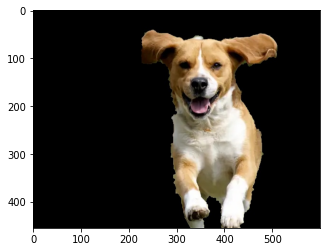

In [ ]:
#@title Show output { display-mode: "form" }
image=cv2.imread("/content/Dog_output.jpg")
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

#4. CÀI ĐẶT SONG SONG

##4.1. Song song hoá lần 1

###4.1.1. Thiết kế

Mô hình được thiết kế theo sự kế thừa của mô hình tuần tự jit lần 1

<img src="https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/Illustrated%20image/Model/parallel_v1.JPG" 
     width="1152" 
     height="360" />

Ý tưởng song song hóa:
- Việc thay thế 2 dòng for trong duyệt mảng bằng việc dùng cuda.grid(2) ở 4 hàm trong mô hình thiết kế của jit lần 1

###4.1.2. Thực nghiệm

In [ ]:
#@title Run { display-mode: "form" }
%%time
!python /content/Parallel_v1.py /content/Dog.JPG

CPU times: user 960 ms, sys: 152 ms, total: 1.11 s
Wall time: 3min 30s


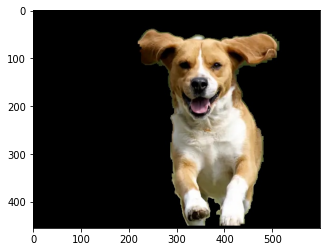

In [ ]:
#@title Show output { display-mode: "form" }
image=cv2.imread("/content/Dog_output.jpg")
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

### 4.1.3. Rút kinh nghiệm song song hoá lần 1

Lý do: Một số phần chưa thể cuda.jit do thực hiện tính toán và tạo mảng trong hàm khiến cho cuda.jit không thể tạo kernel.  
Hướng giải quyết: Thực hiện tái cấu trúc code phần SLIC Superpixels dựa trên file jit lần 2 cho việc song song hoá lần tiếp theo

##4.2.Song song hóa lần 2

###4.2.1. Thiết kế 

Mô hình song song hoá được dựa vào jit version 2.

<img src="https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/Illustrated%20image/Model/parallel_v2.JPG" 
     width="1152"  />


Tương tự version 1, ta song song những đoạn có 2 vòng for với range bằng kích thước height và width của image.  
Sử dụng các biến global để chưa Image, tránh việc copy data nhiều lần cũng như tăng tốc thêm được một ít thời gian.  
Sử dụng njit(parallel=True) với các vòng lặp đơn giản để parallel trên CPU.

###4.2.2. **Thực nghiệm dự kiến**

In [ ]:
#@title Run { display-mode: "form" }
%%time
!python /content/parallel_v2.py /content/Dog.JPG

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
CPU times: user 92.5 ms, sys: 17.6 ms, total: 110 ms
Wall time: 16 s


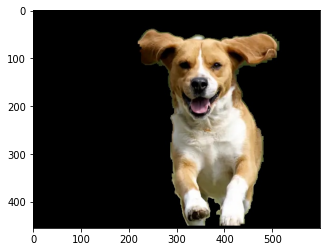

In [ ]:
#@title Show output { display-mode: "form" }
image=cv2.imread("/content/Dog_output.jpg")
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

#5. SAI SỐ

Ở đây ta tính sai số của của BGR2Lab của mô hình giữa jit_v2 và parallel_v2

In [ ]:
#@title Sai Số BGR2Lab { display-mode: "form" }

from numba import cuda,jit
import math
import numpy as np
#cv2
img=cv2.imread("/content/Dog.JPG")
BRG_2_LAB_CV2=cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
@cuda.jit
def BGR2Lab_kernel(in_pixels, out_pixels):
    col, row = cuda.grid(2)
    if row < out_pixels.shape[0] and col < out_pixels.shape[1]:
        X = (float(in_pixels[row][col][2]) * 0.412453 + float(in_pixels[row][col][1]) * 0.357580 + float(in_pixels[row][col][0]) * 0.180423)/95.047
        Y = (float(in_pixels[row][col][2]) * 0.212671 + float(in_pixels[row][col][1]) * 0.715160 + float(in_pixels[row][col][0]) * 0.072169)/100.000
        Z = (float(in_pixels[row][col][2]) * 0.019334 + float(in_pixels[row][col][1]) * 0.119193 + float(in_pixels[row][col][0]) * 0.950227)/108.883
        if Y>0.008856:
            Y=Y**float(1/3)
        else:
            Y=(7.787*Y)+16/116
        if X>0.008856:
            X=X**float(1/3)
        else:
            X=(7.787*X)+16/116
        if Z>0.008856:
            Z=Z**float(1/3)
        else:
            Z=(7.787*Z)+16/116
        out_pixels[row][col][0]=116*Y-16
        out_pixels[row][col][1]=500*(X-Y)+128
        out_pixels[row][col][2]=200*(Y-Z)+128
BLOCK_SIZE=[32,32]
width=img.shape[1]
height=img.shape[0]
#initialize grid_size
grid_size_x=math.ceil(width/BLOCK_SIZE[0])
grid_size_y=math.ceil(height/BLOCK_SIZE[1])
grid_size=(grid_size_x,grid_size_y)
labImage=np.zeros(img.shape,dtype=np.float64)
#COPY DATA TO DEVICE
d_Img=cuda.to_device(img)
d_labImage=cuda.device_array(labImage.shape, dtype=np.float64)
#CALL KERNEL
BGR2Lab_kernel[grid_size,BLOCK_SIZE](d_Img,d_labImage)
#COPY DATA TO HOST
labImage=d_labImage.copy_to_host()
@jit(nopython=True, cache=True)
def BGR2Lab(in_pixels, out_pixels):
    '''
    convert color image to Lab
    #https://docs.opencv.org/3.4/de/d25/imgproc_color_conversions.html#color_convert_rgb_lab
    prams:
        in_pixels: input color image
        out_pixels: output cielab image
    '''
    #XYZ_colvolution = np.array([[0.412453, 0.357580, 0.180423],
    #                            [0.212671, 0.715160, 0.072169],
    #                            [0.019334, 0.119193, 0.950227]])
    for row in range(len(in_pixels)):
        for col in range(len(in_pixels[0])):
            RGB = [float(in_pixels[row][col][2]), float(in_pixels[row][col][1]), float(in_pixels[row][col][0])]

            X = (RGB[0] * 0.412453 + RGB[1] * 0.357580 + RGB[2] * 0.180423)/95.047
            Y = (RGB[0] * 0.212671 + RGB[1] * 0.715160 + RGB[2] * 0.072169)/100.000
            Z = (RGB[0] * 0.019334 + RGB[1] * 0.119193 + RGB[2] * 0.950227)/108.883

            if Y>0.008856:
                Y=Y**(1/3)
            else:
                Y=(7.787*Y)+16/116
            if X>0.008856:
                X=X**(1/3)
            else:
                X=(7.787*X)+16/116
            if Z>0.008856:
                Z=Z**(1/3)
            else:
                Z=(7.787*Z)+16/116
            L=116*Y-16
            a=500*(X-Y)+128
            b=200*(Y-Z)+128
            out_pixels[row][col][0]=L
            out_pixels[row][col][1]=a
            out_pixels[row][col][2]=b
labImage_jit=np.zeros(shape=img.shape, dtype=np.float64)
BGR2Lab(img,labImage_jit)
print("Sai số của convert BGR2Lab jit và cuda: ", np.mean(np.abs(labImage_jit-labImage)))

Sai số của convert BGR2Lab jit và cuda:  8.339610104105546e-15


Đối với output thì qua góc nhìn cảm quan thì ta thấy tất cả mô hình ở phía trên cho kết quả giống nhau

#6. TỔNG KẾT QUÁ TRÌNH THỰC NGHIỆM

Đối với Non jit, jit version 1, parallel version 1, jit version 2 sẽ có mục chỉ là ước tính thời gian chạy do thời gian chạy quá lâu. Nó sẽ được đánh dấu *.


##6.1. Tổng thời gian chạy thử của các mô hình

Chi tiết tại [đây](https://colab.research.google.com/drive/1Uf6rruTo7wDgZ8h47HaaxB5ip1xA8_IR#scrollTo=k4XBjAo4q3G2)  
(*Thời gian chạy từng thời điểm khác nhau sẽ khác nhau*)  
Đơn vị tính (giây)
<table>
<thead>
<tr>
<th>Image</th>
<th>Non jit</th>
<th>jit version 1</th>
<th>parallel version 1</th>
<th>jit version 2</th>
<th>parallel version 2</th>
</tr>
</thead>
<tbody>
<tr>
<td>600x455</td>
<td>227</td>
<td>190</td>
<td>190</td>
<td>71</td>
<td>16</td>
</tr>

</tbody>
</table>

Ta có thể thấy sau nhiều lần cải tiến thì parallel version 2 có tốc độ nhanh gấp 14 lần so với ban đầu (non jit)

## 6.2. Thời gian chạy chi tiết

### 6.2.1. Chạy thử của các mô hình


Kích thước hình ảnh 600x455. Chi tiết quá trình chạy tại [đây](https://colab.research.google.com/drive/1Uf6rruTo7wDgZ8h47HaaxB5ip1xA8_IR#scrollTo=fjyk_lT88Ntf&line=2&uniqifier=1)

*Graussian Blur của nonjit sử dụng opencv*  
Đơn vị tính (giây) 

<table>
<thead>
    <tr>
        <th>Model</th>
        <th>Load model</th>
        <th>SLIC</th>
        <th>Grabcut</th>
        <th>Segmentation Mask</th>
        <th>Graussian Blur</th>
        <th>Merge</th>
    </tr>
</thead>
<tbody>
    <tr>
        <td>non jit</td>
        <td>5.3</td>
        <td>229.2</td>
        <td>1.53</td>
        <td>0.55</td>
        <td>0.008*</td>
        <td>0.57</td>
    </tr>
    <tr>
        <td>jit_v1</td>
        <td>4.3</td>
        <td>178.2</td>
        <td>1.53</td>
        <td>0.3</td>
        <td>2.5</td>
        <td>0.23</td>
    </tr>
    <tr>
        <td>parallel_v1</td>
        <td>4.3</td>
        <td>179.1</td>
        <td>1.53</td>
        <td>0.52</td>
        <td>2.65</td>
        <td>0.2</td>
    </tr>
    <tr>
        <td>jit_v2</td>
        <td>4.3</td>
        <td>61.6</td>
        <td>1.53</td>
        <td>1.15</td>
        <td>2.3</td>
        <td>0.22</td>
    </tr>
    <tr>
        <td>parallel_v2</td>
        <td>4.26</td>
        <td>5.45</td>
        <td>1.51</td>
        <td>1.40</td>
        <td>1.02</td>
        <td>0.8</td>
    </tr>
</tbody>
</table>

### 6.2.2. So sánh thời gian chạy của parallel version 2 và jit version 2 đối với những hình ảnh lớn hơn.

Chi tiết quá trình chạy tại [đây](https://colab.research.google.com/drive/1Uf6rruTo7wDgZ8h47HaaxB5ip1xA8_IR#scrollTo=Gu7y3bYwCouw&line=1&uniqifier=1)  
jit_v2 với ảnh 3268x2488 thời gian xử lý SLIC được dự đoán bằng x10 thời gian chạy hoàn tất 1 vòng lặp*

<table>
<thead>
    <tr>
        <th>Model</th>
        <th>Size Image</th>
        <th>SLIC</th>
        <th>Grabcut</th>
        <th>Segmentation Mask</th>
        <th>Graussian Blur</th>
        <th>Merge</th>
    </tr>
</thead>
<tbody>
    <tr>
        <td>jit_v2</td>
        <td>1066x799</td>
        <td>592</td>
        <td>18</td>
        <td>2.46</td>
        <td>6.96</td>
        <td>0.35</td>
    </tr>
    <tr>
        <td>parallel_v2</td>
        <td>1066x799</td>
        <td>10.65</td>
        <td>18.79</td>
        <td>2.81</td>
        <td>1.13</td>
        <td>0.81</td>
    </tr>
    <tr>
        <td>jit_v2</td>
        <td>3268x2488</td>
        <td>~24000*</td>
        <td>54.26</td>
        <td>20.87</td>
        <td>70.68</td>
        <td>0.77</td>
    </tr>
    <tr>
        <td>parallel_v2</td>
        <td>3268x2488</td>
        <td>274.99</td>
        <td>57.38</td>
        <td>21.6</td>
        <td>1.48</td>
        <td>1.2</td>
    </tr>
</tbody>
</table>

Một thử nghiệm khác tính: thời gian chạy của SLIC trong parallel_v2 của hình ảnh 3268x2488 với 16060 superpixels với SLIC trong skimage. Khi đó parallel_v2 chỉ đạt 274.99s, còn skimage.segmentation.slic đạt 124.25s.

## 6.3. Hình ảnh thực nghiệm

<img src="https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/output/Dog_output.jpg" 
     width="400"  />

*REDDIT - https://www.reddit.com/r/dogpictures/comments/6puk20/i_am_speed_because_i_am_speedy/*

<img src="https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/output/Cow_1_output.jpg" 
     width="400"  />
     
*A image from Cocodataset - https://cocodataset.org/#home*

<img src="https://raw.githubusercontent.com/kimdinhloc/Applied_Parallel_Programming_HK2_2021_2022/main/output/Cow-bw_output.jpg" 
     width="400"  />
     
*WIKIPEDIA - https://upload.wikimedia.org/wikipedia/commons/0/05/Cow-bw.JPG *

#7. KINH NGIỆM TÍCH LUỸ TỪ ĐỒ ÁN

Mỗi thành viên trong nhóm đã học được những gì từ đồ án

**1712898 - TRẦN VIỆT VĂN**

- Sử dụng python và song song hóa ứng dụng để giảm thời gian chạy
- Làm việc trong nhóm và sử dụng Git

**1712787 - NGUYỄN VĂN THÌN**

- Sử dụng git để quản lý source code và làm việc nhóm dựa trên github.
- Song song hoá ứng dụng bằng ngôn ngữ Python bằng cách sử dụng jit.

**1712568 - KIM ĐÌNH LỘC**

- Viết kernel bằng numba.
- Xử lý ảnh

#TÀI LIỆU HÌNH ẢNH

WIKIPEDIA - https://upload.wikimedia.org/wikipedia/commons/0/05/Cow-bw.JPG  
REDDIT - https://www.reddit.com/r/dogpictures/comments/6puk20/i_am_speed_because_i_am_speedy/  
Cocodataset - https://cocodataset.org/#home

# TÀI LIỆU THAM KHẢO

"GrabCut": interactive foreground extraction using iterated graph cuts. [Chi tiết tại đây!](https://cvg.ethz.ch/teaching/cvl/2012/grabcut-siggraph04.pdf)


Achanta, Radhakrishna, et al. Slic superpixels. No. REP_WORK. 2010. [Chi tiết tại đây!](https://infoscience.epfl.ch/record/149300)

Le, Cuong Vo, et al. "Superpixel-based background removal for accuracy salience person re-identification." 2016 IEEE International Conference on Consumer Electronics-Asia (ICCE-Asia). IEEE, 2016. [Chi tiết tại đây!](https://ieeexplore.ieee.org/abstract/document/7804806/)

